# 1. Importing Libraries and Path Definitions

## **a. Summary, At a Glance**


*   **Task:** Arrhythmia Classification, 3 classes
*   **Dataset:** MIT-BIH ECG dataset, Dataset website: [Here](https://physionet.org/content/mitdb/1.0.0/), INCART ECG dataset, website: [Here](https://physionet.org/content/incartdb/1.0.0/)
*   **Model:** CNN_LSTM with Attention

# **Main Parts of the Study:**

1.   **Part A: Installing Packages and Basic Visualization of ECG**
2.   **Part B: Denoising, R-Peak Detection, Segmentation**
3.   **Part C: Dataset Loading**
4.   **Part D: Train-Test Splitting and Class Balancing**
5.   **Part E: Model Building and Training**
6.   **Part F: Results**

# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**


In [501]:
%pip install wfdb
%pip install PyWavelets
%pip install imbalanced-learn
%pip install seaborn
# %pip install tensorflow==2.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [502]:
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [503]:
# from google.colab import drive
# drive.mount('/content/drive')

In [504]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.10.1
Num GPUs Available: 1


In [505]:
# Base project folder
project_path = r"F:\ML"  

# Figures/images
figure_path = os.path.join(project_path, "images") + os.sep

# MIT-BIH dataset
RECORDS_MITDB = os.path.join(project_path, "dataset", "mitdb", "RECORDS")
DATA_ROOT_MITDB = os.path.join(project_path, "dataset", "mitdb") + os.sep

# INCART dataset
RECORDS_INCART = os.path.join(project_path, "dataset", "incartdb", "RECORDS") 
DATA_ROOT_INCART = os.path.join(project_path, "dataset", "incartdb") + os.sep

# Logs + models
logdir = os.path.join(project_path, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_path = os.path.join(project_path, "models", "ecg_model_dann.h5")

osj_mitdb = os.path.join 
osj_incart = os.path.join

# 2. Data Loading

In [506]:
patient_ids_mitdb = pd.read_csv(RECORDS_MITDB, header=None)[0].to_numpy()
patient_ids_mitdb

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234], dtype=int64)

In [507]:
patient_ids_incart = pd.read_csv(RECORDS_INCART, header=None)[0].to_numpy()
patient_ids_incart

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], dtype=object)

### Denoise

In [508]:
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

### Loading MIT BIH Dataset

In [509]:
# Read ECG signals and corresponding label
def getDataSet_mit(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet_mit = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info_mit = wfdb.io.rdsamp(osj_mitdb(DATA_ROOT_MITDB, number))
    channels_mit = info_mit['sig_name']
    channel1_mit, channel2_mit = channels_mit[0], channels_mit[1]
    print(channel1_mit, channel2_mit)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record_mit = wfdb.rdrecord(DATA_ROOT_MITDB + number, channel_names=[channel1_mit])
    data_mit = record_mit.p_signal.flatten()
    rdata_mit = denoise(data=data_mit)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation_mit = wfdb.rdann(DATA_ROOT_MITDB + number, 'atr')
    Rlocation_mit = annotation_mit.sample
    Rclass_mit = annotation_mit.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation_mit.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type_mit = Rclass_mit[i]
            lable_mit = ecgClassSet_mit.index(beat_type_mit)  # when beat is like '+' or other it will go on except loop
            x_train_mit = rdata_mit[Rlocation_mit[i] - 99:Rlocation_mit[i] + 201]
            X_data.append(x_train_mit)
            Y_data.append(lable_mit)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [510]:
# Load the dataset and preprocess it
def loadData_mit():
    numberSet_mit = patient_ids_mitdb
    dataSet_mit = []
    lableSet_mit = []
    for n in numberSet_mit:
        # getDataSet(n, dataSet, lableSet)
        dataSet_mit, lableSet_mit = getDataSet_mit(str(n), dataSet_mit, lableSet_mit)

    # Turn numpy array, scramble the order
    dataSet_mit = np.array(dataSet_mit).reshape(-1, 300)
    lableSet_mit = np.array(lableSet_mit).reshape(-1, 1)
    train_ds_mit = np.hstack((dataSet_mit, lableSet_mit))
    np.random.shuffle(train_ds_mit)

    # dataset and its label set
    X = train_ds_mit[:, :300]
    Y = train_ds_mit[:, 300]
    return X, Y

In [511]:
X_mit, Y_mit = loadData_mit()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

### Loading INCART Dataset

In [512]:
from scipy.signal import resample_poly

# Read ECG signals and corresponding label
def getDataSet_incart(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet_incart = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info_incart = wfdb.io.rdsamp(osj_mitdb(DATA_ROOT_INCART, number))
    channels_incart = info_incart['sig_name']
    channel1_incart, channel2_incart = channels_incart[1], channels_incart[6]
    print(channel1_incart, channel2_incart)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record_incart = wfdb.rdrecord(DATA_ROOT_INCART + number, channel_names=[channel1_incart])
    data_incart = record_incart.p_signal.flatten()
    rdata_incart = denoise(data=data_incart)
    rdata_incart = resample_poly(rdata_incart, 257, 360)



    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation_incart = wfdb.rdann(DATA_ROOT_INCART + number, 'atr')
    Rlocation_incart = annotation_incart.sample
    Rclass_incart = annotation_incart.symbol

    # Rescale R-peak locations to match resampled (360 Hz) signal
    Rlocation_incart = np.round(Rlocation_incart * 360 / 257).astype(int)

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation_incart.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type_incart = Rclass_incart[i]
            lable_incart = ecgClassSet_incart.index(beat_type_incart)  # when beat is like '+' or other it will go on except loop
            x_train_incart = rdata_incart[Rlocation_incart[i] - 99:Rlocation_incart[i] + 201]
            if len(x_train_incart) == 300:
                X_data.append(x_train_incart)
                Y_data.append(lable_incart)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [513]:
# Load the dataset and preprocess it
def loadData_incart():
    numberSet_incart = patient_ids_incart

    dataSet_incart = []
    lableSet_incart = []
    for n in numberSet_incart:
        # getDataSet(n, dataSet, lableSet)
        dataSet_incart, lableSet_incart = getDataSet_incart(n, dataSet_incart, lableSet_incart)

    # Turn numpy array, scramble the order
    dataSet_incart = np.array(dataSet_incart).reshape(-1, 300)
    lableSet_incart = np.array(lableSet_incart).reshape(-1, 1)
    train_ds_incart = np.hstack((dataSet_incart, lableSet_incart))
    np.random.shuffle(train_ds_incart)

    # dataset and its label set
    X = train_ds_incart[:, :300]
    Y = train_ds_incart[:, 300]
    return X, Y

In [514]:
X_incart, Y_incart = loadData_incart()

II V1
reading I01 ECG data...
II V1
reading I02 ECG data...
II V1
reading I03 ECG data...
II V1
reading I04 ECG data...
II V1
reading I05 ECG data...
II V1
reading I06 ECG data...
II V1
reading I07 ECG data...
II V1
reading I08 ECG data...
II V1
reading I09 ECG data...
II V1
reading I10 ECG data...
II V1
reading I11 ECG data...
II V1
reading I12 ECG data...
II V1
reading I13 ECG data...
II V1
reading I14 ECG data...
II V1
reading I15 ECG data...
II V1
reading I16 ECG data...
II V1
reading I17 ECG data...
II V1
reading I18 ECG data...
II V1
reading I19 ECG data...
II V1
reading I20 ECG data...
II V1
reading I21 ECG data...
II V1
reading I22 ECG data...
II V1
reading I23 ECG data...
II V1
reading I24 ECG data...
II V1
reading I25 ECG data...
II V1
reading I26 ECG data...
II V1
reading I27 ECG data...
II V1
reading I28 ECG data...
II V1
reading I29 ECG data...
II V1
reading I30 ECG data...
II V1
reading I31 ECG data...
II V1
reading I32 ECG data...
II V1
reading I33 ECG data...
II V1
read

In [515]:
train_ds_mit = loadData_mit()
train_ds_incart = loadData_incart()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

# 3. Assigning Appropriate Class Labels

### MIT-BIH

In [516]:
# 15 level to 5 level conversion
Y_5classmit = np.copy(Y_mit)

for i in range(Y_mit.shape[0]):
  # print(i)
  if 0 <= Y_mit[i] <= 4:
    Y_5classmit[i] = 0
  if 5 <= Y_mit[i] <= 8:
    Y_5classmit[i] = 1
  if 9 <= Y_mit[i] <= 10:
    Y_5classmit[i] = 2
  if Y_mit[i] == 11:
    Y_5classmit[i] = 3
  if 12 <= Y_mit[i] <= 14:
    Y_5classmit[i] = 4

print('MIT-BIH 5 Class Mapping Done')

MIT-BIH 5 Class Mapping Done


In [517]:
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5classmit)

In [518]:
ecg_data_mit = X_mit[:, :300]
ecg_label_mit = Y_5classmit.reshape(-1, 1)

In [519]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data_mit, ecg_label_mit))

In [520]:
# Keep only N, S, V classes (labels 0, 1, 2)
ecg_data_mit = ecg_dataset_5[:, :300]
ecg_label_mit = ecg_dataset_5[:, 300]
selected_indices = np.where((ecg_label_mit == 0) | (ecg_label_mit == 1) | (ecg_label_mit == 2))[0]

ecg_data_mit = ecg_data_mit[selected_indices]
ecg_label_mit = ecg_label_mit[selected_indices]

ecg_dataset_5 = np.hstack((ecg_data_mit, ecg_label_mit.reshape(-1, 1)))

### INCART

In [521]:
incart_mapping = {
    0: 'N', 1: 'L', 2: 'R', 3: 'e', 4: 'j',   # Map to AAMI class 0 (Normal)
    5: 'A', 6: 'a', 7: 'J', 8: 'S',           # Map to AAMI class 1 (Supraventricular)
    9: 'V', 10: 'r',                          # Map to AAMI class 2 (Ventricular)
    11: 'F',                                 # Map to AAMI class 3 (Fusion)
    12: 'P', 13: 'Q', 14: 'f', 15: '/',       # Map to AAMI class 4 (Unknown)
}

Y_5classincart = np.copy(Y_incart)

for i in range(Y_incart.shape[0]):
    label = incart_mapping[Y_incart[i]]
    if label in ['N', 'L', 'R', 'e', 'j']:
        Y_5classincart[i] = 0
    elif label in ['A', 'a', 'J', 'S']:
        Y_5classincart[i] = 1
    elif label in ['V', 'r']:
        Y_5classincart[i] = 2
    elif label == 'F':
        Y_5classincart[i] = 3
    elif label in ['P', 'Q', 'f', '/']:
        Y_5classincart[i] = 4

print('INCART 5 Class Mapping Done')

INCART 5 Class Mapping Done


In [522]:
from collections import Counter

Y_5class_list = list(Y_5classincart)
Counter(Y_5class_list)

Counter({0.0: 77901, 2.0: 10439, 1.0: 949, 3.0: 119, 4.0: 5})

In [523]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_3class = LabelEncoder().fit_transform(Y_5classincart)

In [524]:
ecg_data_incart = X_incart[:, :300]
ecg_label_incart = Y_5classincart.reshape(-1, 1) # otherwise np.hstack will not work

In [525]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_3 = np.hstack((ecg_data_incart, ecg_label_incart))

In [526]:
# Keep only N, S, V classes (labels 0, 1, 2)

ecg_data_incart = ecg_dataset_3[:, :300]
ecg_label_incart = ecg_dataset_3[:, 300]
selected_indices = np.where((ecg_label_incart == 0) | (ecg_label_incart == 1) | (ecg_label_incart == 2))[0]

print(len(ecg_data_incart))

ecg_data_incart = ecg_data_incart[selected_indices]
ecg_label_incart = ecg_label_incart[selected_indices]

ecg_dataset_3 = np.hstack((ecg_data_incart, ecg_label_incart.reshape(-1, 1)))

89413


## Per Class Amount Checking

In [527]:
# Convert ndarray to dataframe
df_ecg_mit = pd.DataFrame(ecg_dataset_5)
class_data_mit = df_ecg_mit[300].value_counts()
class_data_mit

300
0.0    90472
2.0     7229
1.0     2775
Name: count, dtype: int64

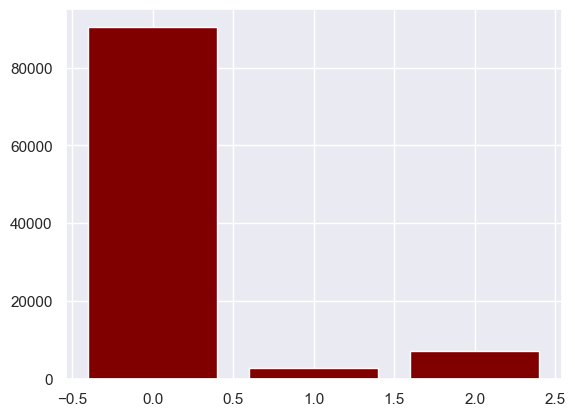

In [528]:
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

In [529]:
# Convert ndarray to dataframe
df_ecg_incart = pd.DataFrame(ecg_dataset_3)
class_data_incart = df_ecg_incart[300].value_counts()
class_data_incart

300
0.0    77901
2.0    10439
1.0      949
Name: count, dtype: int64

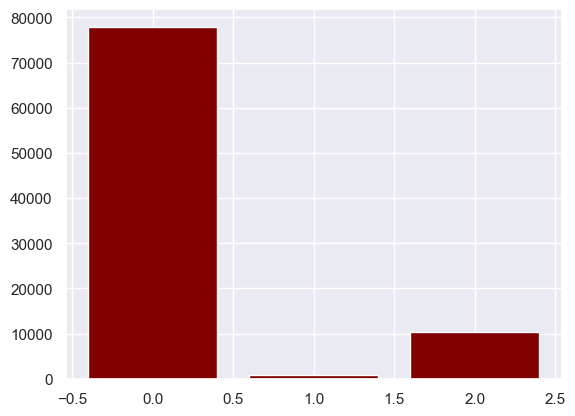

In [530]:
plt.bar(class_data_incart.index, class_data_incart.values, color ='maroon')
plt.show()

## **D2: Train-Test Spliting**
**Note: Class Balance should be done on Training Data Only. Not Testing Data.**

In [531]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data_mit = ecg_dataset_5[:, :300]
ecg_label_mit = ecg_dataset_5[:, 300]
x_train_mit, x_test_mit, y_train_mit, y_test_mit = train_test_split(ecg_data_mit, ecg_label_mit,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [532]:
# reshaping for using hstack function
y_train_mit = y_train_mit.reshape(-1, 1)
y_test_mit = y_test_mit.reshape(-1, 1)
train_data_mit = np.hstack((x_train_mit, y_train_mit))
test_data_mit = np.hstack((x_test_mit, y_test_mit))

In [533]:
#  converting dataframe
train_data_mit = pd.DataFrame(train_data_mit)
test_data_mit = pd.DataFrame(test_data_mit)

In [534]:
# saving the test data (in imbalanced condition)
file_name_mit = DATA_ROOT_MITDB + 'test_data_mit.pkl'
test_data_mit.to_pickle(file_name_mit)

300
0.0    72395
2.0     5751
1.0     2234
Name: count, dtype: int64


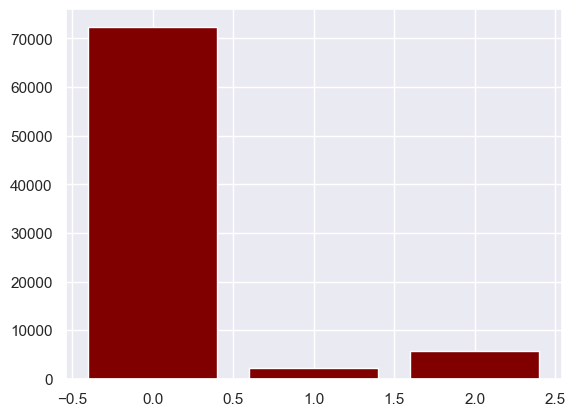

In [535]:
# Imblanced training data graph ploting
class_data_mit = train_data_mit[300].value_counts()
print(class_data_mit)
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

## **D3: Class balancing by undersampling and SMOTE**
**SMOTE** stands for '**Synthetic Minority Oversampling Technique**'.
Plan for train data
1. Class 1: Randomly selected 50000 data
2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

In [536]:
# extracting class 0 and 4 others class
train_data_0_mit = train_data_mit.loc[(train_data_mit[300] == 0)]
train_data_1234_mit = train_data_mit.loc[(train_data_mit[300] != 0)]

In [537]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled_mit=train_data_0_mit.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled_mit = train_data_0_resampled_mit.to_numpy()

In [538]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr_mit = train_data_1234_mit.to_numpy()
X_4cl_mit, y_4cl_mit = train_data_1234_arr_mit[:, :-1], train_data_1234_arr_mit[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy_mit = {1:50000, 2:50000}
oversample_mit = SMOTE(sampling_strategy=strategy_mit)
X_4cl_mit = X_4cl_mit.astype('float32')

X_mit, y_mit = oversample_mit.fit_resample(X_4cl_mit, y_4cl_mit)

y_mit = y_mit.reshape(-1, 1)
train_data_1234_resampled_mit = np.hstack((X_mit, y_mit))

In [539]:
# Join the class 0 and 1234
train_data_resampled_mit = np.vstack((train_data_0_resampled_mit, train_data_1234_resampled_mit))

# shuffle the data, needed for proper training
np.take(train_data_resampled_mit,np.random.permutation(train_data_resampled_mit.shape[0]),axis=0,out=train_data_resampled_mit)

array([[ 0.04745115,  0.04931939,  0.05266269, ...,  0.06316136,
         0.04525864,  1.        ],
       [-0.24640612, -0.23378557, -0.22131242, ..., -0.14152323,
        -0.13874851,  2.        ],
       [-0.23025615, -0.24071693, -0.24970242, ..., -0.94867009,
        -0.9813111 ,  0.        ],
       ...,
       [ 0.02439837,  0.03729027,  0.04865664, ..., -0.34666866,
        -0.34629142,  1.        ],
       [-0.34741339, -0.3492496 , -0.36110535, ..., -0.91390312,
        -0.92975992,  2.        ],
       [-0.15748532, -0.15291713, -0.14699709, ..., -0.10484847,
        -0.0795958 ,  1.        ]])

300
1.0    50000
2.0    50000
0.0    50000
Name: count, dtype: int64


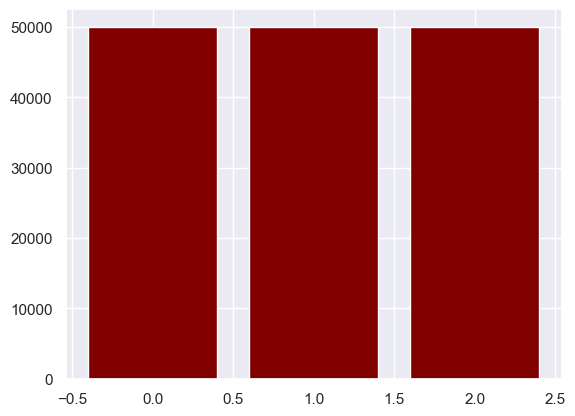

In [540]:
# blanced training data graph ploting
train_data_r_mit = pd.DataFrame(train_data_resampled_mit)
class_data_mit = train_data_r_mit[300].value_counts()
print(class_data_mit)
plt.bar(class_data_mit.index, class_data_mit.values, color ='maroon')
plt.show()

# save balanced training data
file_name = DATA_ROOT_MITDB + 'train_data_SMOTE_mit.pkl'
train_data_r_mit.to_pickle(file_name)

In [541]:
data_bal_mit = np.array(class_data_mit)
data_bal2_mit = data_bal_mit.reshape(1, 3)

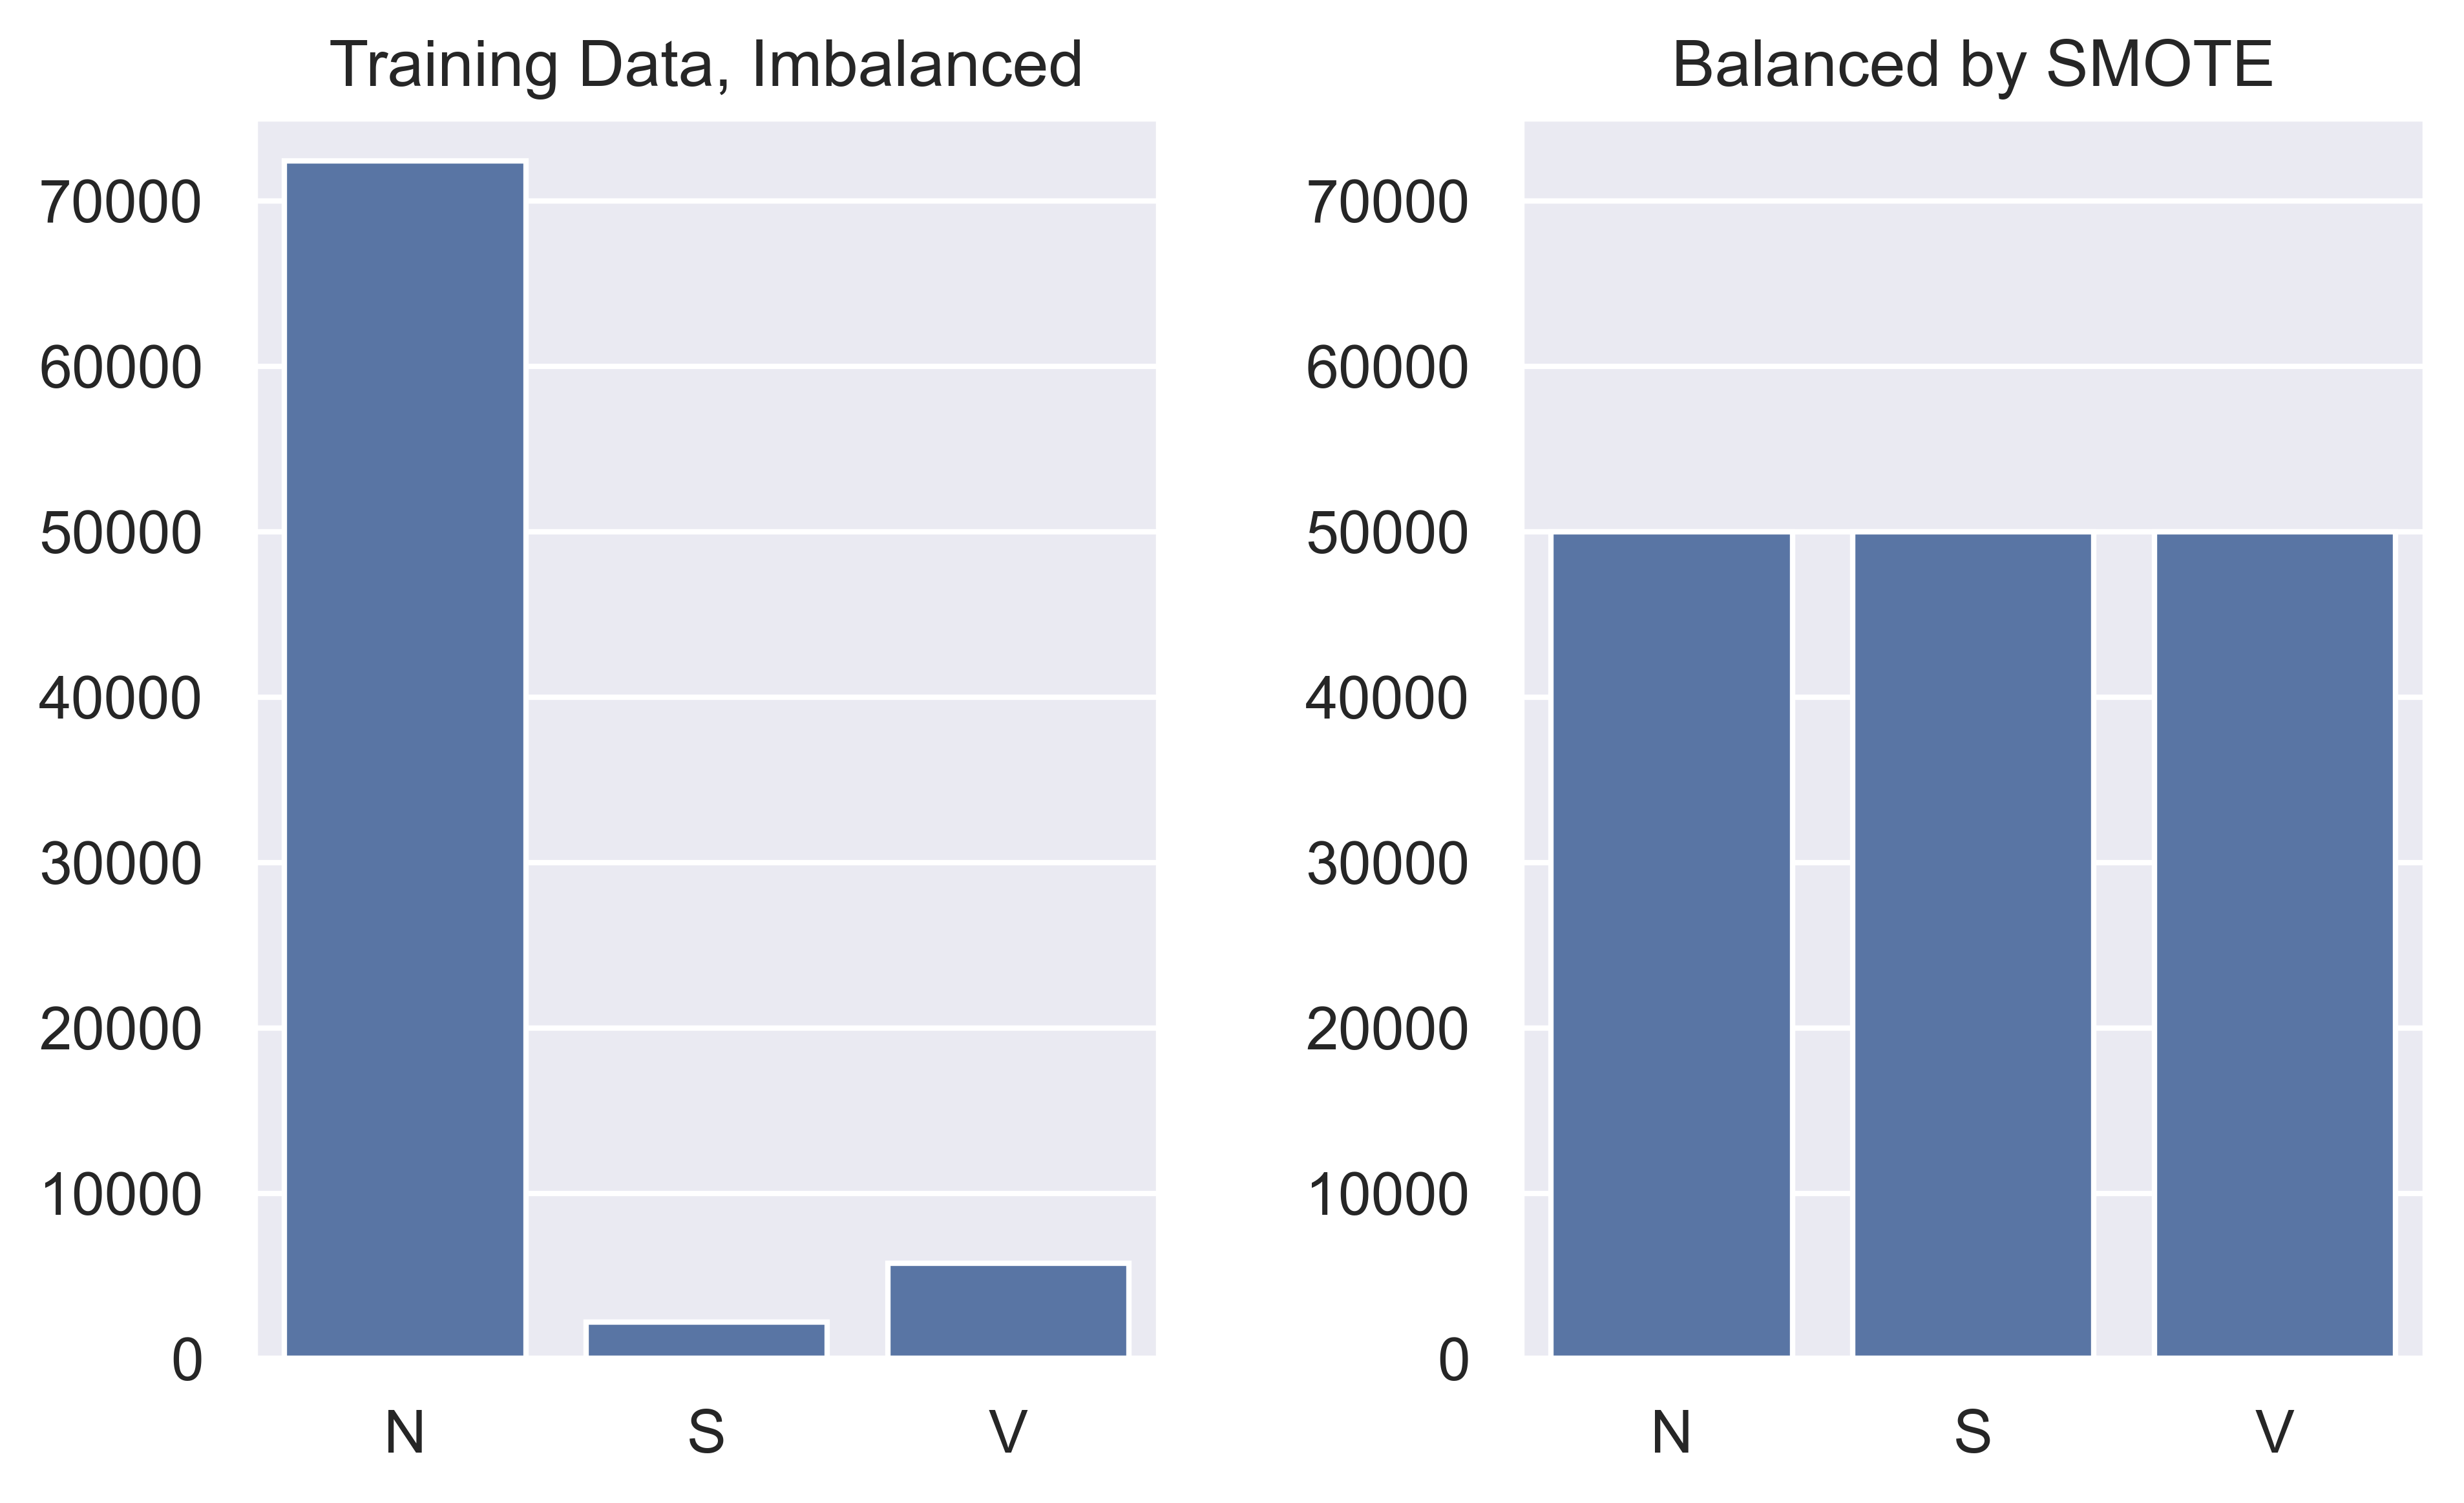

In [542]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V'], y = [72420, 2212, 5774])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V'], y = class_data_mit.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)



In [543]:
ecg_dataset_3

array([[ 0.10247452,  0.10293173,  0.10338781, ...,  0.20902504,
         0.20953012,  0.        ],
       [ 2.51132367,  2.51718075,  2.52393146, ...,  2.42314636,
         2.42517007,  0.        ],
       [-1.18335577, -1.16869966, -1.15361553, ..., -0.84082512,
        -0.85598734,  0.        ],
       ...,
       [-2.53124555, -2.51436955, -2.4972058 , ..., -2.57513311,
        -2.55460875,  0.        ],
       [ 4.11334702,  4.14804172,  4.18287738, ...,  3.92951907,
         3.92733338,  0.        ],
       [ 0.92006683,  0.9198755 ,  0.91985928, ...,  0.89255534,
         0.8912433 ,  0.        ]])

In [544]:
ecg_dataset_5

array([[ 0.83044173,  0.84384309,  0.85389954, ..., -0.16908056,
        -0.17758028,  0.        ],
       [-0.16203009, -0.15870903, -0.15613345, ..., -0.01814227,
        -0.01395796,  0.        ],
       [ 0.12116248,  0.11590817,  0.11017886, ...,  0.09504976,
         0.10191916,  0.        ],
       ...,
       [-0.30680782, -0.30948893, -0.31251739, ..., -0.2837909 ,
        -0.28672877,  0.        ],
       [-0.52517426, -0.52270548, -0.52192797, ..., -0.47105029,
        -0.47073815,  0.        ],
       [-0.19362542, -0.19718292, -0.20209005, ..., -0.29447036,
        -0.30761588,  0.        ]])

In [545]:
ecg_data_incart = ecg_dataset_3[:, :300] 
ecg_label_incart = ecg_dataset_3[:, 300] 

x_train_incart, x_test_incart, y_train_incart, y_test_incart = train_test_split(ecg_data_incart, ecg_label_incart,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

# Reshape to match model input [B, T, C]
x_train_mit = x_train_mit[..., np.newaxis]
x_test_mit  = x_test_mit[..., np.newaxis]
x_train_incart = x_train_incart[..., np.newaxis]
x_test_incart  = x_test_incart[..., np.newaxis]

y_train_mit = y_train_mit.astype(int)
y_test_mit  = y_test_mit.astype(int)
y_train_incart = y_train_incart.astype(int)
y_test_incart  = y_test_incart.astype(int)

In [546]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5classincart = LabelEncoder().fit_transform(Y_5classincart)

In [547]:
ecg_data_incart = X_incart[:, :300]
ecg_label_incart = Y_5classincart.reshape(-1, 1) # otherwise np.hstack will not work

In [548]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_3 = np.hstack((ecg_data_incart, ecg_label_incart))

# **Part E: Model Building and Training**
A **CNN-LSTM and attention** based hybrid model is formulated.

## **E1: Attention Mechanism**
**Convolutional Block Attention Module** ([CBAM](https://arxiv.org/abs/1807.06521)) consists two parts (i) **channel attention**, (ii) spatial attention. ECG is an 1D signal and 1-lead ECG is used in the modle.Therefore, only channel attention is only used.

In [549]:
import tensorflow as tf

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_layer_one = tf.keras.layers.Dense(self.filters // self.ratio,
                                                     activation='relu', 
                                                     kernel_initializer='he_normal',
                                                     use_bias=True,
                                                     bias_initializer='zeros')
        self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                                     kernel_initializer='he_normal',
                                                     use_bias=True,
                                                     bias_initializer='zeros')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Avg pool
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)   
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        # Max pool
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)    
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        attention = tf.keras.layers.Add()([avg_pool, max_pool])
        attention = tf.keras.layers.Activation('sigmoid')(attention)
        attention = tf.expand_dims(attention, axis=1)  # shape (batch, 1, filters)

        return tf.keras.layers.Multiply()([inputs, attention])

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({
            "filters": self.filters,
            "ratio": self.ratio,
        })
        return config

In [550]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                kernel_size=self.kernel_size,
                strides=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                use_bias=False)

    def call(self, inputs):

        # AvgPool
        avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

        # MaxPool
        max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

        attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

        attention = self.conv2d(attention)


        return tf.keras.layers.multiply([inputs, attention])


In [551]:
#E2: Making Transformer Encoder

#Transformer is designe followed by the encoder given in Attention is all you need paper. Here, input is ECG signal after some convolution layers.

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, MultiHeadAttention, LayerNormalization, BatchNormalization, GlobalAveragePooling1D, Dense, Add, Flatten
from tensorflow.keras.models import Model
import numpy as np

In [552]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dense = tf.keras.layers.Dense(dff, activation='relu')

    def call(self, inputs, training=True):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training=training)
        attention_output = self.layer_norm(inputs + attention_output)

        ffn_output = self.dense(attention_output)
        ffn_output = self.dropout(ffn_output, training=training)
        encoder_output = self.layer_norm(attention_output + ffn_output)

        return encoder_output

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "d_model": self.d_model,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate,
        })
        return config

In [553]:
def positional_encoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return tf.constant(P, dtype=tf.float32)

In [554]:
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_ = lambda_

    def call(self, x):
        lambda_ = self.lambda_

        @tf.custom_gradient
        def _flip_gradients(x):
            def grad(dy):
                return -lambda_ * dy
            return x, grad

        return _flip_gradients(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_": self.lambda_
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [555]:
class LambdaScheduler(tf.keras.callbacks.Callback):
    def __init__(self, layer, max_lambda=1.0, total_epochs=50):
        super().__init__()
        self.layer = layer
        self.max_lambda = max_lambda
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        p = epoch / max(1, self.total_epochs - 1)
        lam = 2.0 / (1.0 + np.exp(-10.0 * p)) - 1.0  # classic DANN schedule
        self.layer.lambda_ = self.max_lambda * lam

# Use:
# grl_layer = [l for l in dann_model.layers if isinstance(l, GradientReversal)][0]
# dann_model.fit(..., callbacks=[LambdaScheduler(grl_layer, max_lambda=1.0, total_epochs=EPOCHS)])


## **E2: CNN-LSTM and attention model architecture**

### **a. Model building**

In [556]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Reshape

In [557]:
def build_feature_extractor(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate):
  # Input layer for the time series data
    input_sequence = Input(shape=(max_sequence_length, num_channels))

    # Convolutional layers

    x = Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu')(input_sequence)
    print(x.shape)
    x = BatchNormalization()(x)
    print(x.shape)
    x = ChannelAttention(16, 8)(x)
    print(x.shape)
    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(32, 8)(x)
    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(64, 8)(x)


    x = MaxPooling1D(pool_size=(3), strides=2, padding='same')(x)

    x = Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = ChannelAttention(128, 8)(x)



    def positional_encoding(seq_len, d, n=10000):
      P = np.zeros((seq_len, d))
      for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
        return tf.constant(P, dtype=tf.float32)


    # Positional Encoding
    positional_encoding = positional_encoding(seq_len = 38, d=128)
    x = x + positional_encoding


    # Transformer Encoder block
    query = x  # 'query' branch is the output from the last Conv1D layer
    value = x  # 'value' branch is also the output from the last Conv1D layer

    # Create TransformerEncoder class instance
    transformer_encoder = TransformerEncoder(num_heads=num_heads, d_model=d_model, dff=dff, dropout_rate=dropout_rate)
    encoder_output = transformer_encoder(query)  # Call the TransformerEncoder instance with 'query' input

    x = Flatten()(encoder_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)


    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_sequence, outputs=output)

    return model

In [558]:
def build_dann_model(max_sequence_length=300, num_channels=1,
                     d_model=128, num_heads=4, dff=128, dropout_rate=0.2,
                     num_classes=5, grl_lambda=1.0):
    # shared feature extractor
    feature_extractor = build_feature_extractor(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate)
    input_sequence = feature_extractor.input
    features = feature_extractor.output  # [B, d_model]

    # ---- Task (label) head ----
    t = Dense(128, activation='relu')(features)
    t = Dropout(0.2)(t)
    task_output = Dense(num_classes, activation='softmax', name='task_output')(t)

    # ---- Domain head (with GRL) ----
    grl = GradientReversal(lambda_=grl_lambda)(features)
    d = Dense(128, activation='relu')(grl)
    d = Dropout(0.2)(d)
    # Binary domain: 0=source, 1=target. If more domains, switch to softmax.
    domain_output = Dense(1, activation='sigmoid', name='domain_output')(d)

    model = Model(inputs=input_sequence, outputs=[task_output, domain_output], name="DANN_CNN_Transformer")
    return model


### **b. Hyperparameter Tuning**
Many architectures of model is found by changing hyperparameters.
* Model: with or without channel or spatial attention.
* CNN Filters: Number of filters in each Conv layer is changing like 4, 16, 32, 64, 128 etc.
* LSTM Units: Number of units of two LSTM layer is varing like 32, 64, 128 etc.

In [559]:
# Hyperparameters
max_sequence_length = 300
num_channels = 1  # For single-channel ECG, set num_channels to 1. For multi-channel, adjust accordingly.
d_model = 128
num_heads = 4
dropout_rate = 0.2
dff = 128
num_classes = 5
grl_lambda = 1.0

# Build the model using the user-defined function
dann_model = build_dann_model(max_sequence_length, num_channels, d_model, num_heads, dff, dropout_rate, num_classes, grl_lambda)

dann_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        'task_output': tf.keras.losses.SparseCategoricalCrossentropy(),
        'domain_output': tf.keras.losses.BinaryCrossentropy()
    },
    metrics={
        'task_output': ['accuracy'],
        'domain_output': ['accuracy']
    },
    weighted_metrics=[],  # <--- add this line to silence the warning
    loss_weights={'task_output': 1.0, 'domain_output': 1.0}
)

dann_model.summary()


(None, 300, 16)
(None, 300, 16)
(None, 300, 16)
Model: "DANN_CNN_Transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300, 1)]     0           []                               
                                                                                                  
 conv1d_32 (Conv1D)             (None, 300, 16)      352         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 300, 16)     64          ['conv1d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 channel_attention_32 (ChannelA

### **c. Model Training**

In [560]:
class LambdaScheduler(tf.keras.callbacks.Callback):
    def __init__(self, layer, max_lambda=1.0, total_epochs=50):
        super().__init__()
        self.layer = layer
        self.max_lambda = max_lambda
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        p = epoch / max(1, self.total_epochs - 1)
        lam = 2.0 / (1.0 + np.exp(-10.0 * p)) - 1.0  # classic DANN schedule
        self.layer.lambda_ = self.max_lambda * lam


In [561]:
# Concatenate source and target
X_mix = np.concatenate([x_train_mit, x_train_incart], axis=0)

# Task labels: source has real labels, target gets dummy (ignored via sample weights)
task_y_src = y_train_mit
task_y_tgt_dummy = np.zeros((x_train_incart.shape[0], 1), dtype=np.int32)


task_y_mix = np.concatenate([task_y_src, task_y_tgt_dummy], axis=0)

# Domain labels: 0 = source, 1 = target
domain_y_src = np.zeros((x_train_mit.shape[0], 1), dtype=np.float32)
domain_y_tgt = np.ones((x_train_incart.shape[0], 1), dtype=np.float32)
domain_y_mix = np.concatenate([domain_y_src, domain_y_tgt], axis=0)

# Sample weights
task_sw = np.concatenate([
    np.ones_like(task_y_src, dtype=np.float32),                      # (num_source_samples, 1)
    np.zeros((x_train_incart.shape[0], 1), dtype=np.float32)
], axis=0)  # source counts, target ignored

domain_sw = np.ones((X_mix.shape[0],), dtype=np.float32)  # both count


**Build, save and then Fit the Model.**
If we have already the saved model, then no need to build, save and fit again.

In [562]:
#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
# logdir = DATA_ROOT_MITDB + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_path = DATA_ROOT_MITDB + "trans1_incart_tomek_25_v2"
# model_path3 = model_path + "m3"

In [564]:
# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

checkpoint_filepath = DATA_ROOT_MITDB + "dann_weights.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, monitor='val_task_output_accuracy',
    mode='max', save_best_only=True
)

task_y_mix = task_y_mix.reshape(-1)      # (N,)
task_sw    = task_sw.reshape(-1)
domain_y_mix = domain_y_mix.reshape(-1)
domain_sw    = domain_sw.reshape(-1)

print("task_y_mix sample:", task_y_mix[:10], type(task_y_mix[0]))
print("domain_y_mix sample:", domain_y_mix[:10], type(domain_y_mix[0]))

print("X_mix shape:", X_mix.shape)
print("task_y_mix shape:", task_y_mix.shape)
print("domain_y_mix shape:", domain_y_mix.shape)
print("task_sw shape:", task_sw.shape)
print("domain_sw shape:", domain_sw.shape)
print(dann_model.output_names)

print("Model outputs:", dann_model.output_names)

# Check NaNs or invalid values
print("NaNs in task_y_mix:", np.isnan(task_y_mix).any())
print("NaNs in domain_y_mix:", np.isnan(domain_y_mix).any())
print("NaNs in task_sw:", np.isnan(task_sw).any())
print("NaNs in domain_sw:", np.isnan(domain_sw).any())

# Check unique labels
print("Unique task_y_mix:", np.unique(task_y_mix))
print("Unique domain_y_mix:", np.unique(domain_y_mix))

task_y_mix   = task_y_mix.astype("int32")   # labels should be int
domain_y_mix = domain_y_mix.astype("int32")
task_sw      = task_sw.astype("float32")    # weights should be float
domain_sw    = domain_sw.astype("float32")
X_mix        = X_mix.astype("float32")


# Train
history = dann_model.fit(
    X_mix,
    {'task_output': task_y_mix, 'domain_output': domain_y_mix},
    batch_size=128,
    epochs=30,
    validation_data=(X_mix, {'task_output': task_y_mix, 'domain_output': domain_y_mix}),
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

# Save model
dann_model.save(model_path)
reloaded = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "GradientReversal": GradientReversal,
        "ChannelAttention": ChannelAttention,
        "TransformerEncoder": TransformerEncoder
        }
)

task_y_mix sample: [0 0 0 0 0 0 0 0 0 1] <class 'numpy.int32'>
domain_y_mix sample: [0 0 0 0 0 0 0 0 0 0] <class 'numpy.int32'>
X_mix shape: (151811, 300, 1)
task_y_mix shape: (151811,)
domain_y_mix shape: (151811,)
task_sw shape: (151811,)
domain_sw shape: (151811,)
['task_output', 'domain_output']
Model outputs: ['task_output', 'domain_output']
NaNs in task_y_mix: False
NaNs in domain_y_mix: False
NaNs in task_sw: False
NaNs in domain_sw: False
Unique task_y_mix: [0 1 2]
Unique domain_y_mix: [0 1]
Epoch 1/30
1187/1187 [==============================] - 28s 24ms/step - loss: 0.9304 - task_output_loss: 0.2389 - domain_output_loss: 0.6915 - task_output_accuracy: 0.9474 - domain_output_accuracy: 0.5295 - val_loss: 0.9291 - val_task_output_loss: 0.2375 - val_domain_output_loss: 0.6916 - val_task_output_accuracy: 0.9474 - val_domain_output_accuracy: 0.5295
Epoch 2/30
1187/1187 [==============================] - 28s 23ms/step - loss: 0.9304 - task_output_loss: 0.2390 - domain_output_loss: 0

In [565]:
# # Task evaluation on source domain only
# task_metrics_src = dann_model.evaluate(
#     x_test_mit,
#     [y_test_mit, np.zeros((x_test_mit.shape[0], 1), dtype=np.float32)],
#     sample_weight=[np.ones_like(y_test_mit, dtype=np.float32), np.ones(x_test_mit.shape[0], dtype=np.float32)],
#     verbose=1
# )
# print("MIT-BIH test metrics (task + domain):", task_metrics_src)

# # Domain evaluation on combined test set
# X_test_mix = np.concatenate([x_test_mit, x_test_incart], axis=0)
# domain_y_test = np.concatenate([
#     np.zeros((x_test_mit.shape[0], 1), dtype=np.float32),
#     np.ones((x_test_incart.shape[0], 1), dtype=np.float32)
# ], axis=0)

# task_y_dummy = np.zeros((X_test_mix.shape[0], 1), dtype=np.int32)

# domain_metrics = dann_model.evaluate(
#     X_test_mix,
#     [task_y_dummy, domain_y_test],
#     sample_weight=[np.zeros_like(task_y_dummy, dtype=np.float32), np.ones_like(domain_y_test, dtype=np.float32)],
#     verbose=1
# )
# print("Domain classifier accuracy:", domain_metrics)


def evaluate_dann_posthoc(model, x_src, y_src, x_tgt, y_tgt=None):
    results = {}

    # --- Task evaluation on source domain ---
    task_metrics_src = model.evaluate(
        x_src,
        [y_src, np.zeros((x_src.shape[0], 1), dtype=np.float32)],
        sample_weight=[np.ones_like(y_src, dtype=np.float32), np.ones(x_src.shape[0], dtype=np.float32)],
        verbose=0
    )
    results['task_accuracy_source'] = task_metrics_src[3]
    results['domain_accuracy_source'] = task_metrics_src[4]

    # --- Domain evaluation on combined set (source + target) ---
    X_mix = np.concatenate([x_src, x_tgt], axis=0)
    domain_y_test = np.concatenate([
        np.zeros((x_src.shape[0], 1), dtype=np.float32),
        np.ones((x_tgt.shape[0], 1), dtype=np.float32)
    ], axis=0)
    task_y_dummy = np.zeros((X_mix.shape[0], 1), dtype=np.int32)

    domain_metrics = model.evaluate(
        X_mix,
        [task_y_dummy, domain_y_test],
        sample_weight=[np.zeros_like(task_y_dummy, dtype=np.float32), np.ones_like(domain_y_test, dtype=np.float32)],
        verbose=0
    )
    results['domain_accuracy_mixed'] = domain_metrics[4]

    # --- Task evaluation on target domain (post-hoc using predict) ---
    if y_tgt is not None:
        task_preds_tgt = model.predict(x_tgt, verbose=0)[0]  # task branch output
        pred_classes = np.argmax(task_preds_tgt, axis=1)
        results['task_accuracy_target'] = np.mean(pred_classes == y_tgt)
    else:
        results['task_accuracy_target'] = None

    # --- Print results ---
    print("\n=== DANN Evaluation ===")
    print(f"Task accuracy (source): {results['task_accuracy_source']:.4f}")
    print(f"Domain accuracy (source): {results['domain_accuracy_source']:.4f}")
    if y_tgt is not None:
        print(f"Task accuracy (target, post-hoc): {results['task_accuracy_target']:.4f}")
    print(f"Domain accuracy (mixed): {results['domain_accuracy_mixed']:.4f}")

    return results


In [566]:
eval_results = evaluate_dann_posthoc(
    dann_model,
    x_src=x_test_mit,
    y_src=y_test_mit,
    x_tgt=x_test_incart,
    y_tgt=y_test_incart   # only for post-hoc evaluation
)


=== DANN Evaluation ===
Task accuracy (source): 0.8995
Domain accuracy (source): 1.0000
Task accuracy (target, post-hoc): 0.8745
Domain accuracy (mixed): 0.5295


### **d. Plotting Accuracy and Loss**
Training and Validation accuray and loss curve plotting.

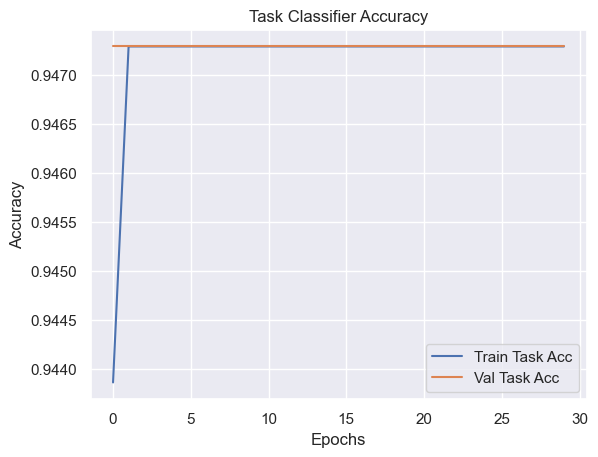

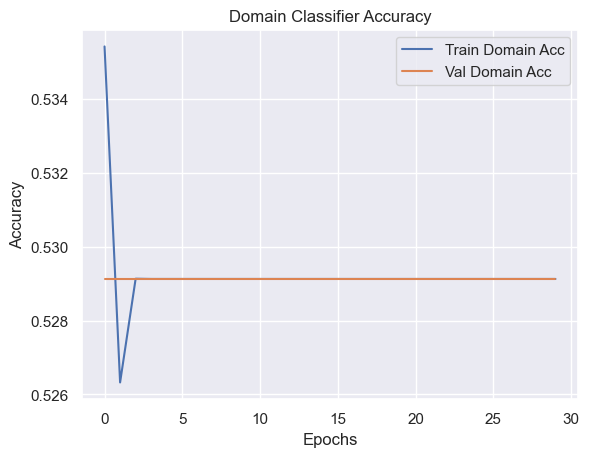

In [ ]:
import matplotlib.pyplot as plt

# Task accuracy
plt.plot(history.history['task_output_accuracy'], label='Train Task Acc')
plt.plot(history.history['val_task_output_accuracy'], label='Val Task Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task Classifier Accuracy')
plt.legend()
plt.show()

# Domain accuracy
plt.plot(history.history['domain_output_accuracy'], label='Train Domain Acc')
plt.plot(history.history['val_domain_output_accuracy'], label='Val Domain Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Domain Classifier Accuracy')
plt.legend()
plt.show()

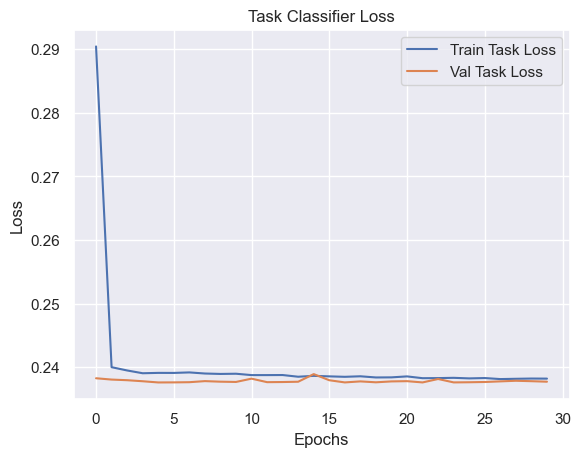

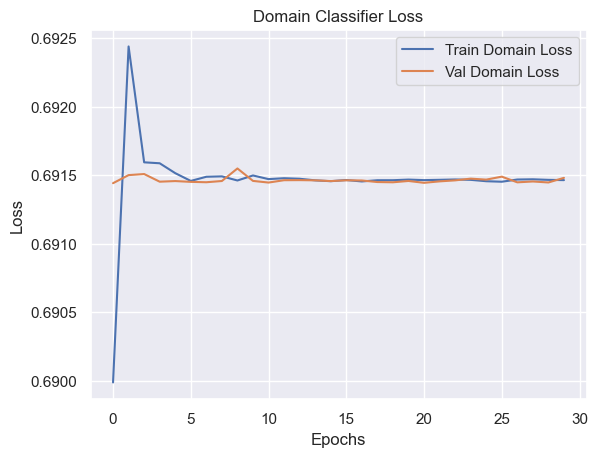

In [ ]:
# Task loss
plt.plot(history.history['task_output_loss'], label='Train Task Loss')
plt.plot(history.history['val_task_output_loss'], label='Val Task Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Task Classifier Loss')
plt.legend()
plt.show()

# Domain loss
plt.plot(history.history['domain_output_loss'], label='Train Domain Loss')
plt.plot(history.history['val_domain_output_loss'], label='Val Domain Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Domain Classifier Loss')
plt.legend()
plt.show()

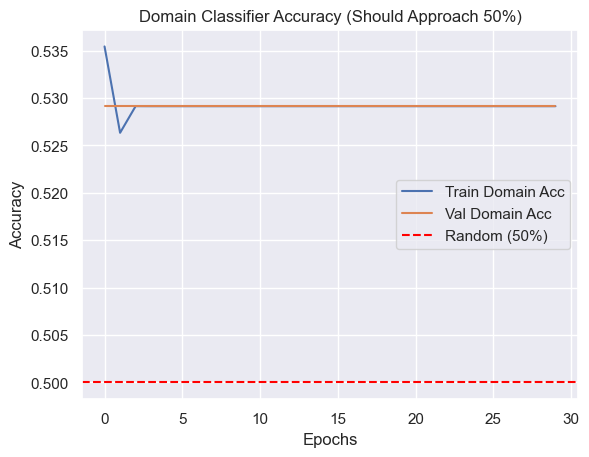

In [ ]:
plt.plot(history.history['domain_output_accuracy'], label='Train Domain Acc')
plt.plot(history.history['val_domain_output_accuracy'], label='Val Domain Acc')
plt.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Domain Classifier Accuracy (Should Approach 50%)')
plt.legend()
plt.show()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir '/content/gdrive/MyDrive/ECG Arrhythmia trying/mit-bih-arrhythmia-database-1.0.0/logs\20221220-113542'

Reusing TensorBoard on port 6006 (pid 9224), started 1:27:04 ago. (Use '!kill 9224' to kill it.)

# **Part F: Results**


## **F1: Classification Accuracy and Confusion Matrix**
The overall classification accuracy and confusion matrix generated by the follwoing code.

**Model Testing**
* a. Using **recently trained** and Saved Model after 30 Epochs.
* b. Using the **best model** saved by *'model checkpoint'* callback.

**a. Using Recently Trained Model**

In [ ]:
# --- Evaluate on MIT (source domain) ---
train_metrics = dann_model.evaluate(
    x_train_mit,
    [y_train_mit, np.zeros((x_train_mit.shape[0], 1), dtype=np.float32)],  # domain=0
    verbose=0
)

test_metrics = dann_model.evaluate(
    x_test_mit,
    [y_test_mit, np.zeros((x_test_mit.shape[0], 1), dtype=np.float32)],    # domain=0
    verbose=0
)

# --- Evaluate on INCART (target domain, with real labels) ---
incart_metrics = dann_model.evaluate(
    x_test_incart,
    [y_test_incart, np.ones((x_test_incart.shape[0], 1), dtype=np.float32)],  # domain=1
    verbose=0
)

# Unpack results (order: total_loss, task_loss, domain_loss, task_acc, domain_acc)
def unpack_metrics(metrics):
    return {
        "total_loss": metrics[0],
        "task_loss": metrics[1],
        "domain_loss": metrics[2],
        "task_acc": metrics[3],
        "domain_acc": metrics[4],
    }

def print_metrics(name, metrics):
    metrics = unpack_metrics(metrics)
    print(f"\n--- {name} ---")
    print(f" Total Loss   : {metrics['total_loss']:.4f}")
    print(f" Task Loss    : {metrics['task_loss']:.4f}")
    print(f" Domain Loss  : {metrics['domain_loss']:.4f}")
    print(f" Task Acc     : {metrics['task_acc']*100:.2f}%")
    print(f" Domain Acc   : {metrics['domain_acc']*100:.2f}%")

print_metrics("Train MIT", train_metrics)
print_metrics("Test MIT", test_metrics)
print_metrics("Test INCART", incart_metrics)

TypeError: in user code:

    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1668, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\metrics\base_metric.py", line 700, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\iaref\miniconda3\envs\tf-gpu\lib\site-packages\keras\metrics\metrics.py", line 3672, in sparse_categorical_accuracy
        if matches.shape.ndims > 1 and matches.shape[-1] == 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


In [ ]:
# evaluate the model
train_loss, train_acc = dann_model.evaluate(x_train_mit, y_train_mit, verbose=0)
test_loss, test_acc = dann_model.evaluate(x_test_mit, y_test_mit, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

ValueError: y_true and y_pred have different structures.
y_true: *
y_pred: ['*', '*']


**b. Using the Best Model**
We saved many checkpoints of the model. Among these checkpoints we will consider the checkpoint which has the largest validation accuracy. Then copy its path and update the model weights.

In [ ]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

In [ ]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(X_train, Y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(X_test, Y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

**Confusion Matrix**

In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [ ]:
# predict
Y_pred = np.argmax(model.predict(X_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(Y_test, Y_pred)

## **F2: Per Class Performance**
Calculating per class Sensitivity, Specificity, Accuracy and F1 score.

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

**a. Recently Trained Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

**b. Best Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model2.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)